# Notebook 2: Regression, regularization and the kernel trick

# Overview 

The goal of this notebook is to get hands-on experience and intuition about regression and regularization. 

We start from a simple task, fitting data with linear models. Formally, this goes under the name of linear regression. We then fit the data with polynomials of different order, which are called polynomial regression.

After that, we test out the effect of applying regularization. We will be concerned with two classes of regularizers: <b> L2-regularization</b> which is often called <b> Ridge-Regression</b> (or <b>Tikhonov regression</b>) and <b> L1-regularization</b> which goes under the name <b>LASSO</b> (and is closely related to <b>Compressed Sensing</b>).

Lastly, we use kernel ridge regression and compare different kernel functions.

We once again emphasize the difference between fitting and predicting. We will see that it is much more difficult to get good out-of-sample performance on a test set (predicting) than it is to get good in-sample performance on the training set (fitting).

## Initialize 
First we load a bunch of libraries...

In [1]:
import numpy as np
%matplotlib inline

from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt, rcParams

## Linear regression

### Expressions for least square linear regression

Consider data of the form $\{(y_i,\mathbf{x}_i)\}$ where the index $i=1\ldots N$ runs over the number of examples in the training data and $\mathbf{x}_i$ is a $d$-dimensional feature (row) vector. For notational convenience, it is useful to define the $N \times d$ <b>design matrix</b> $X$ whose rows, $\textbf{x}_1,\cdots, \textbf{x}_N$, are the examples and columns, $\mathbf{X}_{:,1},\cdots, \mathbf{X}_{:,d}$,  are the measured "features" (i.e. feature predictors). We also denote the $N$-dimensional column vector of sample $i$ as $\mathbf{y}_i$ and the $p$-dimensional column vector of regression parameters $\mathbf{w}\in\mathbb{R}^d$.

For ordinary least square regression (no regularization), we minimize the square loss cost function:

$$
\underset{\textbf{w}\in\mathbb{R}^d}{\operatorname{min}} ||\textbf{Xw}-\textbf{y}||_2^2 = \underset{\textbf{w}\in\mathbb{R}^p}{\operatorname{min}} \,(\mathbf{Xw}-\mathbf{y})^T(\mathbf{Xw}-\mathbf{y}),
$$

or equivalently, in component form,
$$
\underset{\textbf{w}\in\mathbb{R}^d}{\operatorname{min}}   \sum_{i=1}^n (y_i -\mathbf{w}\cdot\mathbf{x}_i)^2.
$$

### Exercise 1: Fit a linear model
Consider a probabilistic process that gives rise to a labeled data set $\{(x,y)\}$. Each data is generated by drawing samples from the equation
$$
    y_i= f(x_i) + \epsilon_i,
$$
where $f(x_i)$ is some fixed, but (possibly unknown) function, and $\epsilon_i$ is a Gaussian, uncorrelate noise variable. We will refer to the $f(x_i)$ as the **true features** used to generate the data. 

After we make this labeled data set $\{(x,y)\}$, we fit a linear model to it. Essentially, we need to determine the model parameter $\mathrm{w}$ by training the model on a **training set**. 

Questions:
<ul>


<li> What is the data dependent error (i.e. fitting error)? How does it change when you increase the noise level of the data set?

<li> Derive the best linear square value $\mathrm{w}$ explicitly by solving the least square problem defined above.


<li> Suppose the samples are generated by the following linear expression: 
    $y_i=\textrm{w}_\text{true}x+\epsilon_i$ where $\epsilon_i\sim\mathcal{N}(0,\sigma^2)$ are i.i.d. Gaussian errors. Can our linear model fit the data when the number of samples $N$ goes to infinity? How does the error of the estimated value of the parameter $\mathrm{w}$ scale as a function of $N$?
    
<li> Suppose the samples are generated by the following linear expression: 
    $y_i=\textrm{w}_\text{true}x^2+\epsilon_i$ where $\epsilon_i\sim\mathcal{N}(0,\sigma^2)$. To what extend does the linear model fit the data? (Hint: compare the error that comes from the noise and the error that comes from the model.)

</ul>

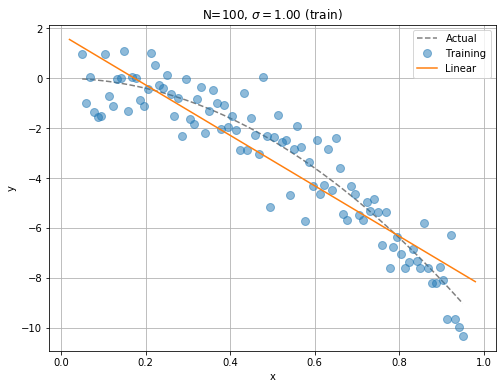

In [10]:
fig = plt.figure(figsize=(8, 6))

# The Training Data
N_train = 100
sigma_train = 1;

# Train on integers
x = np.linspace(0.05,0.95,N_train)
# Draw Gaussian random noise
s = sigma_train*np.random.randn(N_train)

#linear
#fx = 2*x
# second Order
fx = -10*x**2
p0 = plt.plot(x, fx, "--", c='gray', label='Actual')

#add gaussian noise
y = fx+s
p1=plt.plot(x, y, "o", ms=8, alpha=0.5, label='Training')

# Linear Regression : create linear regression object
clf = linear_model.LinearRegression()

# Train the model using the training set
# Note: sklearn requires a design matrix of shape (N_train, N_features). Thus we reshape x to (N_train, 1):
clf.fit(x[:, np.newaxis], y)

# Use fitted linear model to predict the y value:
xplot=np.linspace(0.02,0.98,200) # grid of points, some are in the training set, some are not
linear_plot=plt.plot(xplot, clf.predict(xplot[:, np.newaxis]), label='Linear')


plt.legend(loc='best')
plt.xlabel("x")
plt.ylabel("y")
Title="N=%i, $\sigma=%.2f$"%(N_train,sigma_train)
plt.title(Title+" (train)")


# Linear Filename
filename_train="train-linear_N=%i_noise=%.2f.pdf"%(N_train, sigma_train)

# Saving figure and showing results
plt.savefig(filename_train)
plt.grid()
plt.show()

## Polynomial regression

Instead of writing the naive form of the linear regression, one can write the features in polynomials, so that the model looks like this (if we expand to the 4th order of $x$):
\begin{equation}
        y =  w_0 + w_1 x + w_2 x^2 + w_3 x^3 + w_4 x^4+\epsilon.
    \label{eq:poly-reg}
\end{equation}
An important observation is that this is still a linear model: to see this, imagine creating a new set of features
\begin{equation}
\mathbf{\phi} (\mathbf{x})=
    \begin{bmatrix}
    \phi^{(0)} & \phi^{(1)} & \phi^{(2)} & \phi^{(3)} & \phi^{(4)}
\end{bmatrix} =
    \begin{bmatrix}
    1 & x^1 & x^2 & x^3 & x^4
\end{bmatrix},
\end{equation}
and now we can re-caste polynomial expression into the familiar linear form
\begin{equation}
        y =  w_0 \phi^{(0)} + w_1 \phi^{(1)} + w_2 \phi^{(2)} + w_3 \phi^{(3)} + w_4 \phi^{(4)}+\epsilon,
    \label{eq:poly-reg-2}
\end{equation}

### Exercise 2: polynomial regression, model comparison
For the remainder of the notebook, we will focus on polynomial regression. Our task is to model the data with polynomials and make predictions about the new data that we have not seen.
We will consider two qualitatively distinct situations: 
<ul>
<li> In the first case, the process that generates the underlying data is in the model class we are using to make predictions. For polynomial regression, this means that the functions $f(x_i)$ are themselves polynomials.
<li>In the second case, our data lies outside our model class. In the case of polynomial regression, this could correspond to the case where the $f(x_i)$ is a 10-th order polynomial but $\phi_\alpha(x;\mathbf{w}_\alpha)$ are polynomials of order 1 or 3.
</ul>

In the exercises and discussion we consider 3 model classes:
<ul>
<li> the case where the $\phi_\alpha(x;\mathbf{w}_\alpha)$ are all polynomials up to order 1 (linear models),
<li> the case where the $\phi_\alpha(x;\mathbf{w}_\alpha)$ are all polynomials up to order 3,
<li> the case where the $\phi_\alpha(x;\mathbf{w}_\alpha)$ are all polynomials up to order 10.
</ul>

#### Fitting vs. predicting when the data is in the model class


We start by considering the case:
$$
f(x)=2x.
$$
Then the data is clearly generated by a model that is contained within all three model classes we are using to make predictions (linear models, third order polynomials, and tenth order polynomials). 


Questions:
<ul> 
<li> For $f(x)=2x$, $N_{\mathrm{train}}=10$ and $\sigma=0$ (noiseless case), train the three classes of models (linear, third-order polynomial, and tenth order polynomial) for a training set when $x_i  \in [0,1]$. Make graphs comparing fits for different order of polynomials. Which model fits the data the best?
<li> Do you think that the data that has the least error on the training set will also make the best predictions? Why or why not? Can you try to discuss and formalize your intuition? What can go right and what can go wrong?
<li>Check your answer by seeing how well your fits predict newly generated test data (including on data outside the range you fit on, for example $x \in [0,1.2]$) using the code below. How well do you do on points in the range of $x$ where you trained the model? How about points outside the original training data set? 
<li>Repeat the exercises above for $f(x)=2x$, $N_{\mathrm{train}}=10$, and $\sigma=1$. What changes?
<li>Repeat the exercises above for $f(x)=2x$, $N_{\mathrm{train}}=100$, and $\sigma=1$. What changes?
<li> Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well.
</ul>


#### Fitting vs. predicting when the data is not in the model class
Thus far, we have considered the case where the data is generated using a model contained in the model class. Now consider  $f(x)=2x-10x^5+15x^{10}$. *Notice that the for linear and third-order polynomial the true model $f(x)$ is not contained in model class $\phi_\alpha(x)$* .

Questions:
<ul>
<li> Repeat the exercises above fitting and predicting for $f(x)=2x-10x^5+15x^{10}$ for $N_{\mathrm{train}}=10,100$ and $\sigma=0,1$. Record your observations.
<li> Do better fits lead to better predictions?
<li> What is the relationship between the true model for generating the data and the model class that has the most predictive power? How is this related to the model complexity? How does this depend on the number of data points $N_{\mathrm{train}}$ and $\sigma$?
<li> Summarize what you think you learned about the relationship of knowing the true model class and predictive power.



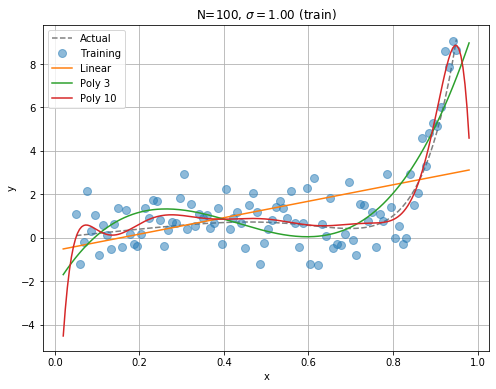

In [32]:
fig = plt.figure(figsize=(8, 6))

# The Training Data
N_train=100
sigma_train=1;

# Train on integers
x=np.linspace(0.05,0.95,N_train)
# Draw Gaussian random noise
s = sigma_train*np.random.randn(N_train)

#linear
#fx = 2*x
# tenth Order
fx = 2*x-10*x**5+25*x**10
p0 = plt.plot(x, fx, "--", c='gray', label='Actual')

#add gaussian noise
y = fx+s
p1 = plt.plot(x, y, "o", ms=8, alpha=0.5, label='Training')

# Linear Regression : create linear regression object
clf = linear_model.LinearRegression()

# Train the model using the training set
# Note: sklearn requires a design matrix of shape (N_train, N_features). Thus we reshape x to (N_train, 1):
clf.fit(x[:, np.newaxis], y)

# Use fitted linear model to predict the y value:
xplot=np.linspace(0.02,0.98,200) # grid of points, some are in the training set, some are not
linear_plot=plt.plot(xplot, clf.predict(xplot[:, np.newaxis]), label='Linear')

# Polynomial Regression
poly3 = PolynomialFeatures(degree=3)
# Construct polynomial features
X = poly3.fit_transform(x[:,np.newaxis])
clf3 = linear_model.LinearRegression()
clf3.fit(X,y)


Xplot=poly3.fit_transform(xplot[:,np.newaxis])
poly3_plot=plt.plot(xplot, clf3.predict(Xplot), label='Poly 3')

# Fifth order polynomial in case you want to try it out
#poly5 = PolynomialFeatures(degree=5)
#X = poly5.fit_transform(x[:,np.newaxis])
#clf5 = linear_model.LinearRegression()
#clf5.fit(X,y)

#Xplot=poly5.fit_transform(xplot[:,np.newaxis])
#plt.plot(xplot, clf5.predict(Xplot), 'r--',linewidth=1)

poly10 = PolynomialFeatures(degree=10)
X = poly10.fit_transform(x[:,np.newaxis])
clf10 = linear_model.LinearRegression()
clf10.fit(X,y)

Xplot=poly10.fit_transform(xplot[:,np.newaxis])
poly10_plot=plt.plot(xplot, clf10.predict(Xplot), label='Poly 10')

plt.legend(loc='best')
#plt.ylim([-7,7])
plt.xlabel("x")
plt.ylabel("y")
Title="N=%i, $\sigma=%.2f$"%(N_train,sigma_train)
plt.title(Title+" (train)")


# Linear Filename
filename_train="train-linear_N=%i_noise=%.2f.pdf"%(N_train, sigma_train)

# Tenth Order Filename
#filename_train="train-o10_N=%i_noise=%.2f.pdf"%(N_train, sigma_train)

# Saving figure and showing results
plt.savefig(filename_train)
plt.grid()
plt.show()


### Exercise 3: validate a model using the test set
To learn the parameters $\mathbf{w}_\alpha$ and select models, we will train our models on a **training set** and then test the effectiveness of the model on a <i>different</i> dataset, the **test set**. The reason we must divide our data into a training and test dataset is that the point of machine learning is to make accurate predictions about new data we have not seen. As we will see below, models that give the best fit to the training data do not necessarily make the best predictions on the test data. This will be a running theme that we will encounter repeatedly in machine learning.  

To measure our ability to predict, we will learn our parameters by fitting our training dataset and then making predictions on our test data set. One common measure of predictive  performance of our algorithm is to compare the predictions,$\{y_j^\mathrm{pred}\}$, to the true values $\{y_j\}$. A commonly employed measure for this is the sum of the mean square-error (MSE) on the test set:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

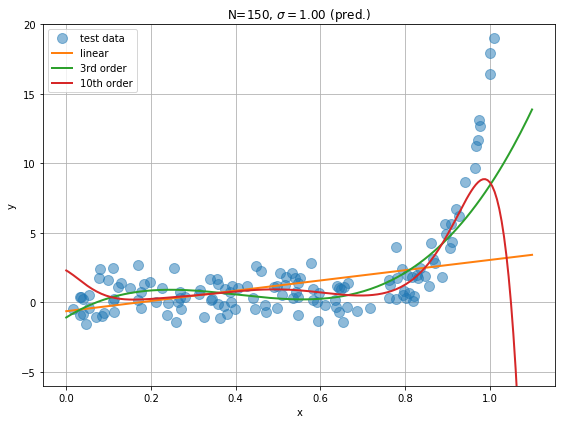

In [24]:
# Generate Test Data
# Number of test data
N_test=150
sigma_test=sigma_train

# Generate random grid points (x) in the interval [0, max_x]:
# Note some points will be drawn outside the training interval
max_x=1.1
x_test=max_x*np.random.random(N_test)

# Draw random Gaussian noise
s_test = sigma_test*np.random.randn(N_test)

# Linear
#y_test=2*x_test+s_test
# Tenth order
y_test=2*x_test-10*x_test**5+25*x_test**10+s_test


# Make design matrices for prediction
x_plot=np.linspace(0,max_x, 200)
X3 = poly3.fit_transform(x_plot[:,np.newaxis])
X10 = poly10.fit_transform(x_plot[:,np.newaxis])

############## PLOTTING RESULTS ##########

fig = plt.figure(figsize=(8, 6))

p1=plt.plot(x_test, y_test, 'o', ms=10, alpha=0.5, label='test data')
p2=plt.plot(x_plot,clf.predict(x_plot[:,np.newaxis]), lw=2, label='linear')
p3=plt.plot(x_plot,clf3.predict(X3), lw=2, label='3rd order')
p10=plt.plot(x_plot,clf10.predict(X10), lw=2, label='10th order')


plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
Title="N=%i, $\sigma=%.2f$"%(N_test,sigma_test)
plt.title(Title+" (pred.)")
plt.tight_layout()
#plt.xlim((0,1.2))
plt.ylim((-6,20))

# Linear Filename
filename_test="pred-linear_N=%i_noise=%.2f.pdf"%(N_test, sigma_test)

# Tenth Order Filename
#filename_test=Title+"pred-o10.pdf"

# Saving figure and showing results
plt.savefig(filename_test)
plt.grid()
plt.show()

## Regularization
We will be concerned with two classes of regularizers: **L2-regularization** (Ridge-Regression),  and **L1-regularization** (LASSO).

In all cases, the idea is to formulate a loss function by taking the sum of the data dependent error $E_D(\mathbf{w})$ and a regularization penalty.

### Ridge Regression
In Ridge Regression, the regularization penalty is taken to be the L2-norm of the parameters
\begin{equation}
E_{ridge}(\mathbf{w})= \dfrac{\lambda}{2} ||\mathbf{w}||_2^2 = \dfrac{\lambda}{2} \mathbf{w}^T \mathbf{w}=\dfrac{\lambda}{2} \sum_{j=1}^d w_j w_j.
\label{eq:ridge}
\end{equation}

Thus, the model is fit by minimizing the sum of the data dependent error $E_D(\mathbf{w})$ and the regularization term $E_{ridge}(\mathbf{w})$:
\begin{equation}
\mathbf{w}_{ridge}(\lambda)= \underset{\mathbf{w}\in\mathcal{R}^d}{\operatorname{argmin}} \dfrac{1}{2}||\mathbf{X}\mathbf{w}-\mathbf{y}||_2^2 + \dfrac{\lambda}{2} ||\mathbf{w}||_2^2.
\end{equation}
Notice that the parameter $\lambda$ controls how much we weigh the fit and regularization term.

### LASSO

We will also be interested in the case where the penalty is the L1-norm of the parameters (sum of absolute values of parameters). This is called LASSO.
$$
E_{LASSO}(\mathbf{w})= \dfrac{\lambda}{2} ||\mathbf{w}||_1 = \dfrac{\lambda}{2} \sum_{j=1}^d |w_j| .
$$
In this case, 
$$
\mathbf{w}_{LASSO}(\lambda)= \underset{\mathbf{w}\in\mathcal{R}^d}{\operatorname{argmin}}  \dfrac{1}{2}||\mathbf{Xw}-\mathbf{y}||_2^2 + \dfrac{\lambda}{2} ||\mathbf{w}||_1.
$$
LASSO tends to give sparse solutions.

### Exercise 4: The effect of regression

<ul>
<li>What do the points $\lambda=0$ and $\lambda=10^5$ correspond to? 
<li>Why in this particular case, LASSO is so much better than Ridge?
<li> What is the qualitative difference between the LASSO path and Ridge Path? Does this agree with your earlier predictions? Can you make some qualitative argument to rationalize this difference?
<li>How do your answers change when you vary the number of examples and training set size?
</ul>

In [113]:
# To see how well we learn, we partition the dataset into a training set with 150 
# as well as a test set with 50 examples. We record their errors respectively.

# The Training Data
N_train=8
sigma_train=3;

# Train on integers
x_train = np.linspace(0.05,0.95,N_train)
# make a 10-dimensional input vector (design matrix)
X_train = np.zeros((N_train,10),dtype=float)
for i in range(N_train):
    for j in range(10):
        X_train[i,j] = x_train[i]**j
        
s = sigma_train*np.random.randn(N_train)     

#linear
#fx = 2*x
# tenth Order
fx = 2*x_train-10*x_train**5+25*x_train**10
#add gaussian noise
y_train = fx + s

# Generate Test Data
# Number of test data
N_test = 50
sigma_test=sigma_train

# Generate random grid points (x) in the interval [0, max_x]:
# Note some points will be drawn outside the training interval
max_x=1.2
x_test=max_x*np.random.random(N_test)
X_test = np.zeros((N_test,10),dtype=float)
for i in range(N_test):
    for j in range(10):
        X_test[i,j] = x_test[i]**j
        
# Draw random Gaussian noise
s_test = sigma_test*np.random.randn(N_test)

# Linear
#y_test=2*x_test+s_test
# Tenth order
y_test=2*x_test-10*x_test**5+25*x_test**10+s_test

train_errors_ridge = list()
test_errors_ridge = list()

train_errors_lasso = list()
test_errors_lasso = list()

/home/bingqing/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.270315130190985, tolerance: 0.01584986642290033
  positive)


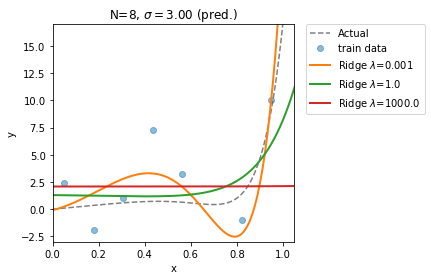

In [114]:
from sklearn import linear_model

# Set up Lasso and Ridge Regression models
ridge = linear_model.Ridge()
lasso = linear_model.Lasso()


# Chooose paths
alphas = np.logspace(-3, 3, 3)

fig = plt.figure(figsize=(6, 4))
max_x=1.1
x_plot=np.linspace(0,max_x, 200)
X_plot = np.zeros((200,10),dtype=float)
fx_plot = 2*x_plot-10*x_plot**5+25*x_plot**10
plt.plot(x_plot, fx_plot, "--", c='gray', label='Actual')

for i in range(200):
    for j in range(10):
        X_plot[i,j] = x_plot[i]**j



plt.plot(x_train, y_train, 'o', ms=6, alpha=0.5, label='train data')
# Initialize coefficients for ridge regression and Lasso

coefs_ridge = []
coefs_lasso=[]
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs_ridge.append(ridge.coef_)
    ridge_fit_results = ridge.predict(X_plot)
    plt.plot(x_plot,ridge_fit_results, lw=2, label='Ridge $\lambda$='+str(a))
    
    # Use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(X_train, y_train))
    test_errors_ridge.append(ridge.score(X_test, y_test))
    
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs_lasso.append(lasso.coef_)
    lasso_fit_results = lasso.predict(X_plot)
    #plt.plot(x_plot,lasso_fit_results, lw=2, label='Lasso $\lambda$='+str(a))
    
    train_errors_lasso.append(lasso.score(X_train, y_train))
    test_errors_lasso.append(lasso.score(X_test, y_test))
    

plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
Title="N=%i, $\sigma=%.2f$"%(N_train,sigma_train)
plt.title(Title+" (pred.)")
plt.tight_layout()
plt.xlim((0,1.05))
plt.ylim((-3,17))

#plt.savefig("effect_of_lasso_few_data.pdf")
plt.savefig("effect_of_ridge_few_data.pdf")

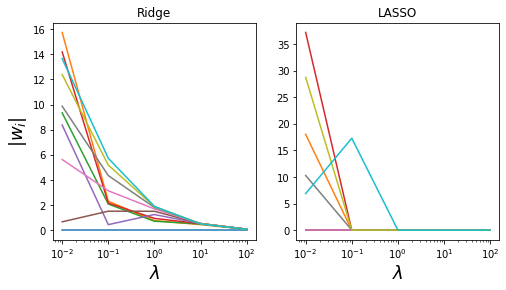

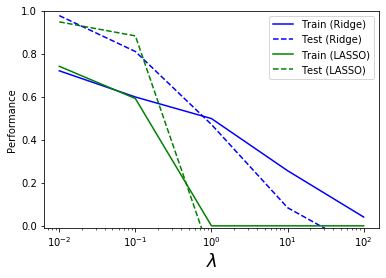

In [97]:
###############################################################################
# Display results
fig = plt.figure(figsize=(8, 4))

# First see how the 10 features we learned scale as we change the regularization parameter
plt.subplot(1,2,1)
plt.semilogx(alphas, np.abs(coefs_ridge))
axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('$|w_i|$',fontsize=18)
plt.title('Ridge')
#plt.savefig("Ridge_sparsity_scale.pdf.pdf")



plt.subplot(1,2,2)
plt.semilogx(alphas, np.abs(coefs_lasso))
axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel(r'$\lambda$',fontsize=18)
#plt.ylabel('$|\mathbf{w}|$',fontsize=18)
plt.title('LASSO')
#plt.savefig("LASSO_sparsity_scale.pdf")
plt.show()



# Plot our performance on both the training and test data
plt.semilogx(alphas, train_errors_ridge, 'b',label='Train (Ridge)')
plt.semilogx(alphas, test_errors_ridge, '--b',label='Test (Ridge)')
plt.semilogx(alphas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(alphas, test_errors_lasso, '--g',label='Test (LASSO)')
#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='upper right')
plt.ylim([-0.01, 1.0])
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('Performance')
plt.savefig("Ridge_LASSO_sparsity_performance.pdf")
plt.show()


## Kernel trick
One can implicitly use basis expansions, and just compute the kernel functions $k(\mathbf{x}_i,\mathbf{x}_j)$.
This is called the *kernel trick*: getting around the computational expense in computing large basis expansions by directly computing kernel functions.  Notice, however, that the kernel trick changes nothing compared with the regression in the feature space:  we get exactly the same predictions as if we computed the basis expansion explicitly, and used traditional linear methods. We just compute the predictions in a different way. 

Kernel ridge regression (KRR) combines ridge regression (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels, this corresponds to a non-linear function in the original space.

###  Exercise 5: Compare kernel ridge regression using different parameters

<ul>
<li> Take a read at the kernel ridge regression page of sklearn:
    https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
<li> What do the two parameters, alpha and gamma, control?
<li> How would you select the best parameters? (Hint: use train/test split.)
<li> Try to use "GridSearchCV" function to locate the best parameters using the notebook below.
</ul>

/home/bingqing/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/bingqing/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1, 'estimator__coef0': 1, 'estimator__degree': 3, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf', 'estimator__kernel_params': None, 'estimator': KernelRidge(alpha=1, coef0=1, degree=3, gamma=0.1, kernel='rbf',
            kernel_params=None), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [1.0], 'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


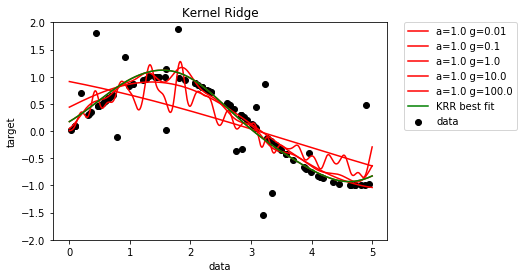

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)

# #############################################################################
# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]

# #############################################################################
# Fit regression model
train_size = 100

tryparam = {"alpha": [1e0],
            "gamma": np.logspace(-2, 2, 5)}

for alpha_now in tryparam["alpha"]:
    for gamma_now in tryparam["gamma"]:
        kr = KernelRidge(kernel='rbf', alpha=alpha_now,gamma=gamma_now)
        kr.fit(X[:train_size], y[:train_size])
        y_kr = kr.predict(X_plot)
        plt.plot(X_plot, y_kr, c='r',label='a='+str(alpha_now)+' g='+str(gamma_now) )

# automatically find the best fit    
kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),
                  param_grid=tryparam)

kr.fit(X[:train_size], y[:train_size])

y_kr = kr.predict(X_plot)
print(kr.get_params())

# #############################################################################
# Look at the results
plt.scatter(X[:100], y[:100], c='k', label='data', zorder=1,
            edgecolors=(0, 0, 0))
plt.plot(X_plot, y_kr, c='g',
         label='KRR best fit')
plt.ylim([-2., 2.0])
plt.xlabel('data')
plt.ylabel('target')
plt.title('Kernel Ridge')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("krr-2.pdf")